<a href="https://colab.research.google.com/github/rajneeshmehta/MlOps/blob/master/Copy_of_stockPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import numpy              as np
import tensorflow         as tf
import pandas             as pd
import pandas_datareader  as pdr
import matplotlib.pyplot  as plt

import math

from sklearn.preprocessing    import MinMaxScaler
from tensorflow               import keras
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers  import Dense
from tensorflow.keras.layers  import LSTM
from sklearn.metrics          import mean_squared_error

from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [ ]:
# Get data from API
df = pdr.get_data_tiingo('AAPL', api_key="fd6e81c1a7b2402f2758e5012b2b9b9e73557e0a")
# df.to_csv('AAPL.csv')
# df=pd.read_csv('AAPL.csv')

# Reset Index to change index to 1,2,3,... 
df=df.reset_index()

# Print last 5 line of dataframe
df.tail()

/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2022-06-02 00:00:00+00:00,151.21,151.2700,146.86,147.830,72348055,151.21,151.2700,146.86,147.830,72348055,0.0,1.0
1254,AAPL,2022-06-03 00:00:00+00:00,145.38,147.9700,144.46,146.900,88570289,145.38,147.9700,144.46,146.900,88570289,0.0,1.0
1255,AAPL,2022-06-06 00:00:00+00:00,146.14,148.5689,144.90,147.030,71598380,146.14,148.5689,144.90,147.030,71598380,0.0,1.0
1256,AAPL,2022-06-07 00:00:00+00:00,148.71,149.0000,144.10,144.345,67808150,148.71,149.0000,144.10,144.345,67808150,0.0,1.0
1257,AAPL,2022-06-08 00:00:00+00:00,147.96,149.8697,147.46,148.580,53950201,147.96,149.8697,147.46,148.580,53950201,0.0,1.0


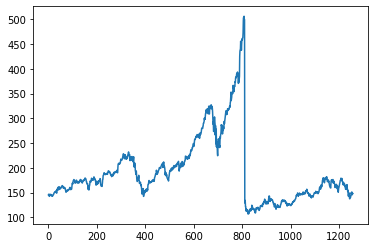

In [ ]:
plt.plot(df['close'])

In [ ]:
# Create New DataFrame with 'close' column
df1 = df['close']

# Convert dataframe to Numpy Array and reshape from (m,) to (m,1)
df1 = np.array(df1).reshape(-1,1)

# Transform Data Range to be (0,1)
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(df1)

# Train Test Split 
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size,test_size

(817, 441)

In [ ]:
# Create helper Function for Creating Dataset
"""
Window Size == Time Step 
We need 0 to (time_step -1) X value to Predict/Train 1 Y value

"""
import numpy
def create_dataset(dataset, time_step=1):
  dataX,dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# Set Window Size == Time Step == 100
time_step = 100

# Invoke create_dataset function to prepare dataset
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
# print(X_train.shape), print(y_train.shape),  print(X_test.shape),  print(y_test.shape)

# Reshape Train and Test set from (m, time_step) to (m, time_step,1)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
# print(X_train.shape), print(X_test.shape)

In [ ]:
# Define a Sequential Model 
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the Model
model.compile(loss='mean_squared_error',optimizer='adam')
# Print the Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the Model
model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=64,
          verbose=1
          )

Epoch 1/100
12/12 [==============================] - 15s 219ms/step - loss: 0.0318 - val_loss: 0.0018
Epoch 2/100
12/12 [==============================] - 0s 38ms/step - loss: 0.0094 - val_loss: 0.0056
Epoch 3/100
12/12 [==============================] - 0s 35ms/step - loss: 0.0078 - val_loss: 8.9639e-04
Epoch 4/100
12/12 [==============================] - 0s 38ms/step - loss: 0.0070 - val_loss: 3.3151e-04
Epoch 5/100
12/12 [==============================] - 0s 35ms/step - loss: 0.0065 - val_loss: 3.4536e-04
Epoch 6/100
12/12 [==============================] - 0s 32ms/step - loss: 0.0066 - val_loss: 3.5357e-04
Epoch 7/100
12/12 [==============================] - 0s 41ms/step - loss: 0.0081 - val_loss: 0.0019
Epoch 8/100
12/12 [==============================] - 0s 34ms/step - loss: 0.0063 - val_loss: 5.1632e-04
Epoch 9/100
12/12 [==============================] - 0s 34ms/step - loss: 0.0058 - val_loss: 3.4386e-04
Epoch 10/100
12/12 [==============================] - 0s 36ms/step - loss:

In [ ]:
# Make prediction on Train and Test data
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

# Inverse Transform prediction from range (0,1) to it's normal range
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

# Print error on Train data
math.sqrt(mean_squared_error(y_train,train_predict))
print()

# Print error on Test data
print(math.sqrt(mean_squared_error(y_test,test_predict)))


152.32224774634656
